In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("/Users/caihao/PycharmProjects/insight_project/")
import warnings

from data.config import raw_data_dir, processed_data_dir, cleaned_data_dir

warnings.filterwarnings('ignore')
tweets_dir  = "/Users/caihao/Dropbox/TEMP/tweets/"

In [100]:
# load data and select features.
df = pd.read_csv(processed_data_dir + '/companies_all_labeled_final.csv')

selected_features = ['country_feature', 'age_feature',\
                     'days_since_first_funding', 'category_score', 'market_score',\
                     'postA_tweet_num', 'postA_tweet_freq', 'postA_tweet_avglength',\
                     'postA_tweet_content_richness', 'postA_tweet_interactiveness',\
                     'tweets_pos_topic_score', 'tweets_neg_topic_score',\
                     'tweets_neg_sent_score', 'tweets_neu_sent_score',\
                     'tweets_pos_sent_score', 'tweets_compound_sent_score',\
                     'WILL',]

new_df = df[selected_features].copy()

In [101]:
# Fix: update category_score as sklearn scores.
# new_category_score = pd.read_csv(processed_data_dir + '/companies_all_category_scores_sklearn.txt',
#                                  delimiter='\s+', names=['new_category_score'], index_col=0)
# new_df['category_score'] = new_category_score['new_category_score']
# new_df.to_csv(processed_data_dir + '/model_lr3_rf2_xgb2_data1.csv', index=False)

In [102]:
# training/test set split.
from sklearn.model_selection import train_test_split  

X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(3847, 16) (2692, 16) (1155, 16)
(3847,) (2692,) (1155,)


## Dummy Classifier (as baseline model)

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       455
           1       0.60      0.61      0.60       700

    accuracy                           0.52      1155
   macro avg       0.49      0.49      0.49      1155
weighted avg       0.51      0.52      0.51      1155



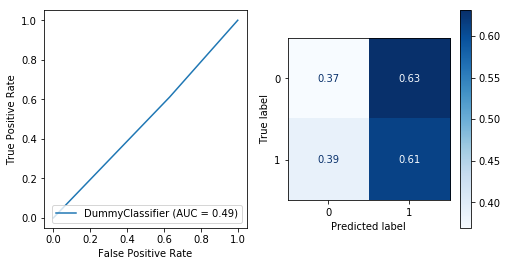

In [193]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, classification_report

# Train classfier.
dummy_clf = DummyClassifier(strategy='stratified', random_state=100)
y_test_predicted = dummy_clf.fit(X_train, y_train).predict(X_test)

# plot ROC curve.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
plot_roc_curve(dummy_clf, X_test, y_test, ax=ax1)

# plot confusion matrix.
plot_confusion_matrix(dummy_clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax2)

# classification report.
print(classification_report(y_test, y_test_predicted))

## Logistic Regression Classifier

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, classification_report

# build classifier and perform hyperparameter tuning using grid search.
lr_clf = LogisticRegression() #Initialize the classfier

param_grid = {
                'penalty': ['l1', 'l2'],
                'C': np.logspace(0, 4, 10),
                'class_weight': ['balanced'],
                'solver': ['newton-cg', 'lbfgs'],
                'max_iter': [10, 20, 50],
             }
grid_clf = GridSearchCV(lg_clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'C': 1291.5496650148827, 'class_weight': 'balanced', 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}


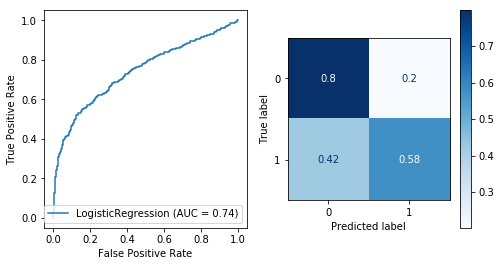

              precision    recall  f1-score   support

           0       0.55      0.80      0.65       455
           1       0.81      0.58      0.68       700

    accuracy                           0.66      1155
   macro avg       0.68      0.69      0.66      1155
weighted avg       0.71      0.66      0.67      1155

postA_tweet_num                 3.753578e+00
days_since_first_funding        2.084940e-01
age_feature                     6.820125e-03
postA_tweet_interactiveness     1.666988e-03
postA_tweet_content_richness    9.284904e-06
country_feature                 5.262415e-06
tweets_pos_topic_score          1.097665e-09
tweets_neg_topic_score         -1.930585e-09
tweets_neg_sent_score          -1.186120e-08
tweets_pos_sent_score          -2.209644e-07
tweets_compound_sent_score     -2.443574e-07
tweets_neu_sent_score          -1.824724e-06
postA_tweet_avglength          -2.488474e-02
category_score                 -2.914017e-02
postA_tweet_freq               -4.054878e-0

In [174]:
# use optimized parameters for the classifier.
# Here, I did not use best parameters from grid search, as I found that it always uses the most complex tree...

lr_clf = LogisticRegression(penalty='l2',
                            C=1000,
                            class_weight='balanced',
                            solver='lbfgs',
                            max_iter=20).fit(X_train, y_train)

y_test_predicted = lr_clf.fit(X_train, y_train).predict(X_test)

# plot ROC curve.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
plot_roc_curve(lr_clf, X_test, y_test, ax=ax1)

# plot confusion matrix.
plot_confusion_matrix(lr_clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax2)
plt.show()

# classification report.
print(classification_report(y_test, y_test_predicted))

# feature importance.
print(pd.Series((np.std(X, 0)*lr_clf.coef_)[0, :], index=selected_features[:-1]).sort_values(ascending=False))

## Random Forest Classifier

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, classification_report

# build classifier and perform hyperparameter tuning using grid search.
rf_clf = RandomForestClassifier() #Initialize the classfier

param_grid = {
                 'n_estimators': [10, 15, 20],
                 'max_depth': [5, 7, 9]
             }
grid_clf = GridSearchCV(rf_clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'max_depth': 9, 'n_estimators': 20}


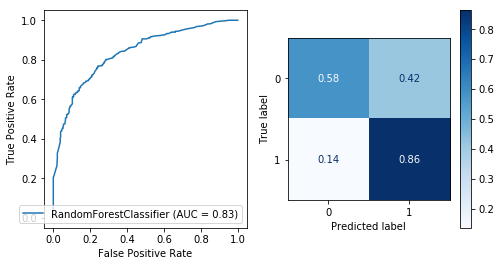

OOB score:  0.8205794947994056
              precision    recall  f1-score   support

           0       0.73      0.58      0.65       455
           1       0.76      0.86      0.81       700

    accuracy                           0.75      1155
   macro avg       0.75      0.72      0.73      1155
weighted avg       0.75      0.75      0.74      1155

tweets_pos_topic_score          0.334161
postA_tweet_num                 0.176515
postA_tweet_interactiveness     0.141796
country_feature                 0.105858
days_since_first_funding        0.074403
postA_tweet_content_richness    0.047577
age_feature                     0.046330
tweets_neg_topic_score          0.031890
postA_tweet_freq                0.014382
tweets_pos_sent_score           0.011127
postA_tweet_avglength           0.005695
market_score                    0.005385
category_score                  0.003741
tweets_compound_sent_score      0.001141
tweets_neu_sent_score           0.000000
tweets_neg_sent_score      

In [195]:
# use optimized parameters for the classifier.
# Here, I did not use best parameters from grid search, as I found that it always uses the most complex tree...

rf_clf = RandomForestClassifier(max_depth=3,
                                n_estimators=5,
                                random_state=7,
                                oob_score=True).fit(X_train, y_train)

y_test_predicted = rf_clf.predict(X_test)

# plot ROC curve.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
plot_roc_curve(rf_clf, X_test, y_test, ax=ax1)

# plot confusion matrix.
plot_confusion_matrix(rf_clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax2)
plt.show()

# OOB score is a better metric of evaluating model performance on training set.
print("OOB score: ", clf.oob_score_)

# classification report.
print(classification_report(y_test, y_test_predicted))

# feature importance.
print(pd.Series(rf_clf.feature_importances_, index=selected_features[:-1]).sort_values(ascending=False))

## Gradient Boosting Classifier

In [155]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, classification_report

# build classifier and perform hyperparameter tuning using grid search.
gb_clf = GradientBoostingClassifier() #Initialize the classfier

param_grid = {
                "loss":["deviance"],
                "learning_rate": [0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10],
                "n_estimators":[10],
                "subsample":[1.0],
                "criterion": ["friedman_mse"],
                "min_samples_split": [2],
                "min_samples_leaf": [1],
                "max_depth":[3],
                "max_features":["log2","sqrt"],
             }
grid_clf = GridSearchCV(gb_clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}


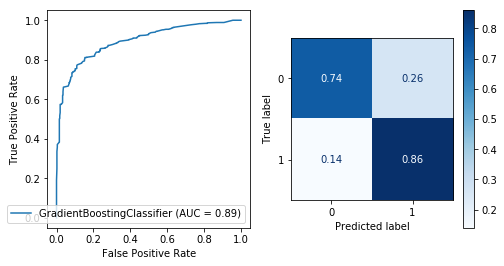

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       455
           1       0.83      0.86      0.85       700

    accuracy                           0.81      1155
   macro avg       0.80      0.80      0.80      1155
weighted avg       0.81      0.81      0.81      1155

postA_tweet_num                 0.363692
tweets_pos_topic_score          0.163965
postA_tweet_freq                0.138937
days_since_first_funding        0.124066
postA_tweet_interactiveness     0.113892
postA_tweet_content_richness    0.034030
tweets_neu_sent_score           0.028599
tweets_neg_topic_score          0.015039
age_feature                     0.010896
tweets_pos_sent_score           0.003607
country_feature                 0.003278
tweets_compound_sent_score      0.000000
tweets_neg_sent_score           0.000000
postA_tweet_avglength           0.000000
market_score                    0.000000
category_score                  0.000000
dtype: float64


In [194]:
# use optimized parameters for the classifier.
# Here, I did not use best parameters from grid search, as I found that it seems to overfit...

gb_clf = GradientBoostingClassifier(loss="deviance",
                                    learning_rate=0.5,
                                    n_estimators=4,
                                    subsample=1.0,
                                    criterion='friedman_mse',
                                    min_samples_split=2,
                                    min_samples_leaf=2,
                                    max_depth=3,
                                    max_features='log2',
                                    random_state=0).fit(X_train, y_train)

y_test_predicted = gb_clf.predict(X_test)

# plot ROC curve.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
plot_roc_curve(gb_clf, X_test, y_test, ax=ax1)

# plot confusion matrix.
plot_confusion_matrix(gb_clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax2)
plt.show()

# classification report.
print(classification_report(y_test, y_test_predicted))

# feature importance.
print(pd.Series(gb_clf.feature_importances_, index=selected_features[:-1]).sort_values(ascending=False))

## Summary
As seen from above model training and testing, GB Classifier gave the best F1-score.

In [189]:
# Save above models and data.

# with open(cleaned_data_dir + '/model_dummy_final.pkl', 'wb') as f:
#     pickle.dump(dummy_clf, f)

# with open(cleaned_data_dir + '/model_lr_final.pkl', 'wb') as f:
#     pickle.dump(lr_clf, f)

# with open(cleaned_data_dir + '/model_rf_final.pkl', 'wb') as f:
#     pickle.dump(rf_clf, f)

# with open(cleaned_data_dir + '/model_gb_final.pkl', 'wb') as f:
#     pickle.dump(gb_clf, f)

# new_df.to_csv(cleaned_data_dir + '/model_lr_rf_gb_data_final.csv', index=False)